# Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# Load Data

In [2]:
data = load_breast_cancer()
df = pd.DataFrame(data.data, columns = data.feature_names)
df['target'] = data.target
print(df.shape)
print(np.bincount(data.target))

(569, 31)
[212 357]


In [3]:
X = df.drop('target', axis = 1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

Feature correlation with target:

target                     1.000000
smoothness error           0.067016
mean fractal dimension     0.012838
texture error              0.008303
symmetry error             0.006522
fractal dimension error   -0.077972
concavity error           -0.253730
compactness error         -0.292999
worst fractal dimension   -0.323872
mean symmetry             -0.330499
mean smoothness           -0.358560
concave points error      -0.408042
mean texture              -0.415185
worst symmetry            -0.416294
worst smoothness          -0.421465
worst texture             -0.456903
area error                -0.548236
perimeter error           -0.556141
radius error              -0.567134
worst compactness         -0.590998
mean compactness          -0.596534
worst concavity           -0.659610
mean concavity            -0.696360
mean area                 -0.708984
mean radius               -0.730029
worst area                -0.733825
mean perimeter            -0.7

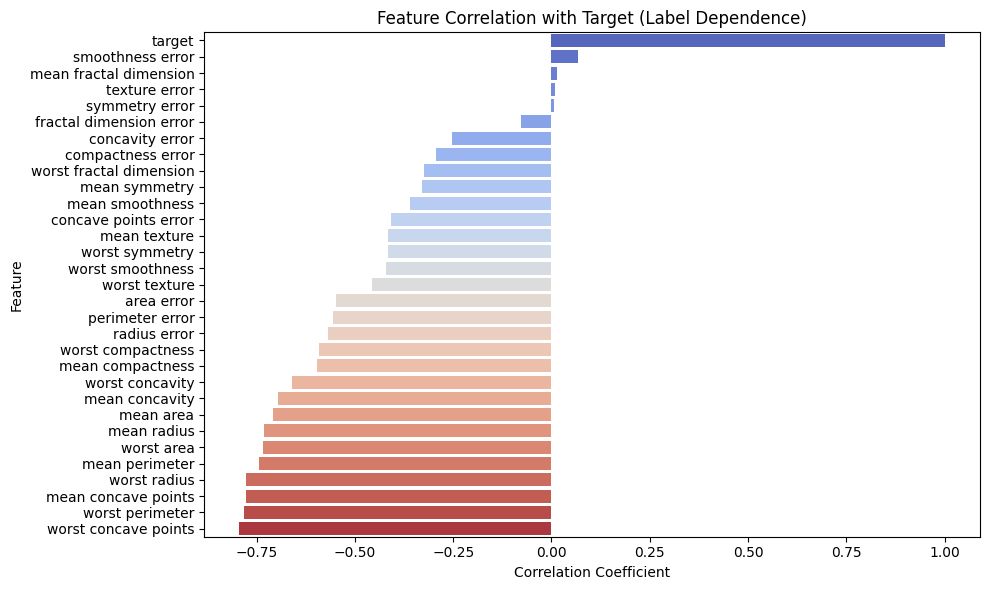

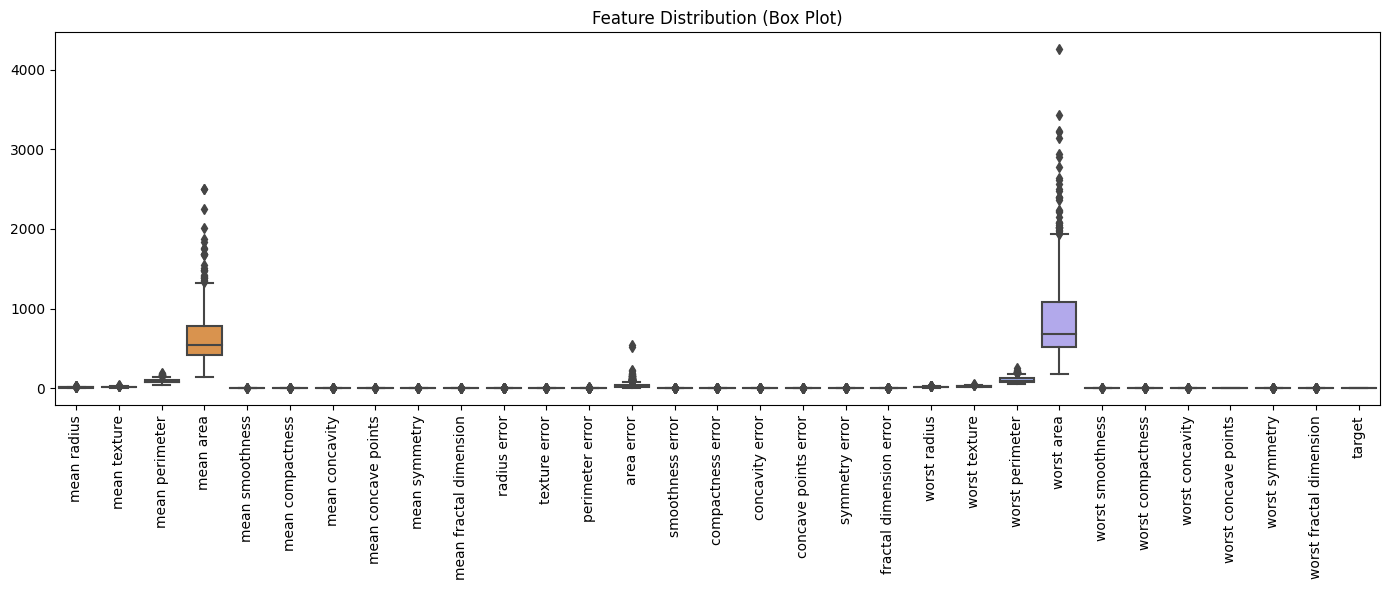

In [4]:
# Compute correlation of each feature with the target
corr_with_target = df.corr()["target"].sort_values(ascending=False)

print("Feature correlation with target:\n")
print(corr_with_target)

# Plot correlation with target
plt.figure(figsize=(10, 6))
sns.barplot(
    x=corr_with_target.values,
    y=corr_with_target.index,
    palette="coolwarm"
)
plt.title("Feature Correlation with Target (Label Dependence)")
plt.xlabel("Correlation Coefficient")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# --- Box Plot for Feature Distributions --- #
plt.figure(figsize=(14, 6))
sns.boxplot(data=df)
plt.title("Feature Distribution (Box Plot)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Data Preprocessing

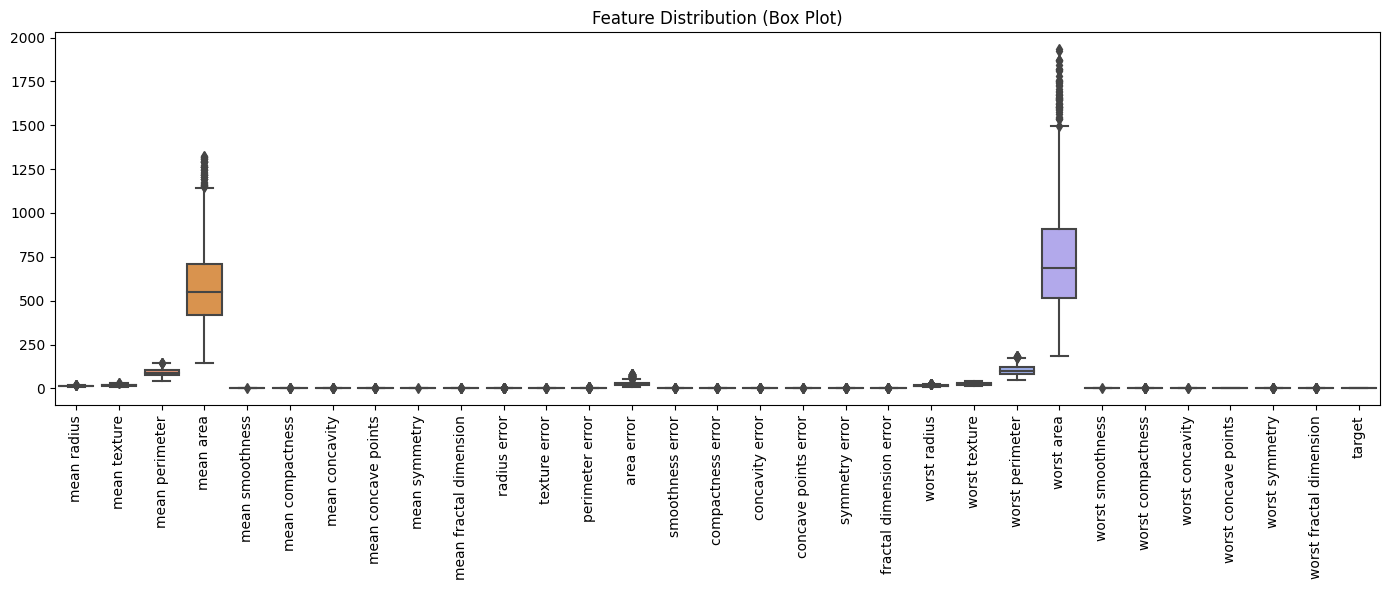

In [5]:
def replace_outliers_with_median(df):
    df_cleaned = df.copy()
    for col in df.columns:
        if df[col].dtype in [np.float64, np.int64]:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower = Q1 - 1.5 * IQR
            upper = Q3 + 1.5 * IQR

            median = df[col].median()

            # Replace outliers with median
            df_cleaned.loc[(df[col] < lower) | (df[col] > upper), col] = median
    return df_cleaned

df = replace_outliers_with_median(df)
plt.figure(figsize=(14, 6))
sns.boxplot(data=df)
plt.title("Feature Distribution (Box Plot)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [6]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.float32) # Since we dont transform y, it stays as a Series. We must convert to np before tensor
y_test_tensor = torch.tensor(y_test.to_numpy(), dtype=torch.float32)

y_train_tensor = y_train_tensor.reshape(-1, 1)  # Shape: [455, 1]
y_test_tensor = y_test_tensor.reshape(-1, 1)

print(X_train_tensor.shape)
print(X_test_tensor.shape)
print(y_train_tensor.shape)
print(y_test_tensor.shape)

torch.Size([455, 30])
torch.Size([114, 30])
torch.Size([455, 1])
torch.Size([114, 1])


# Model Implementation

In [7]:
class LogisticModel(nn.Module):
    def __init__(self, input_dim):
        super(LogisticModel, self).__init__()
        self.linear = nn.Linear(input_dim, 1)

    def forward(self, x):
        outputs = self.linear(x)
        outputs = torch.sigmoid(outputs)
        return outputs

In [8]:
input_dim = X.shape[1]
model = LogisticModel(input_dim)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01) # Fine-tune params here
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.001)

# Train Model

In [9]:
train_losses = []
test_losses = []

epochs = 100
for epoch in range(epochs):
    
    model.train()  # Set model to training mode
    
    train_outputs = model(X_train_tensor)
    train_loss = criterion(train_outputs, y_train_tensor)
    
    optimizer.zero_grad()  # Clear previous gradients
    train_loss.backward()  # Compute gradients
    optimizer.step()       # Update weights
    
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # No gradient computation for evaluation
        # Training loss (already computed above)
        train_losses.append(train_loss.item())
        
        # Test loss
        test_outputs = model(X_test_tensor)
        test_loss = criterion(test_outputs, y_test_tensor)
        test_losses.append(test_loss.item())
    
    # Print progress
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss.item():.4f}, Test Loss: {test_loss.item():.4f}')

Epoch [10/100], Train Loss: 0.2821, Test Loss: 0.2838
Epoch [20/100], Train Loss: 0.1839, Test Loss: 0.1980
Epoch [30/100], Train Loss: 0.1410, Test Loss: 0.1627
Epoch [40/100], Train Loss: 0.1187, Test Loss: 0.1439
Epoch [50/100], Train Loss: 0.1061, Test Loss: 0.1322
Epoch [60/100], Train Loss: 0.0979, Test Loss: 0.1244
Epoch [70/100], Train Loss: 0.0922, Test Loss: 0.1191
Epoch [80/100], Train Loss: 0.0877, Test Loss: 0.1150
Epoch [90/100], Train Loss: 0.0841, Test Loss: 0.1118
Epoch [100/100], Train Loss: 0.0811, Test Loss: 0.1091


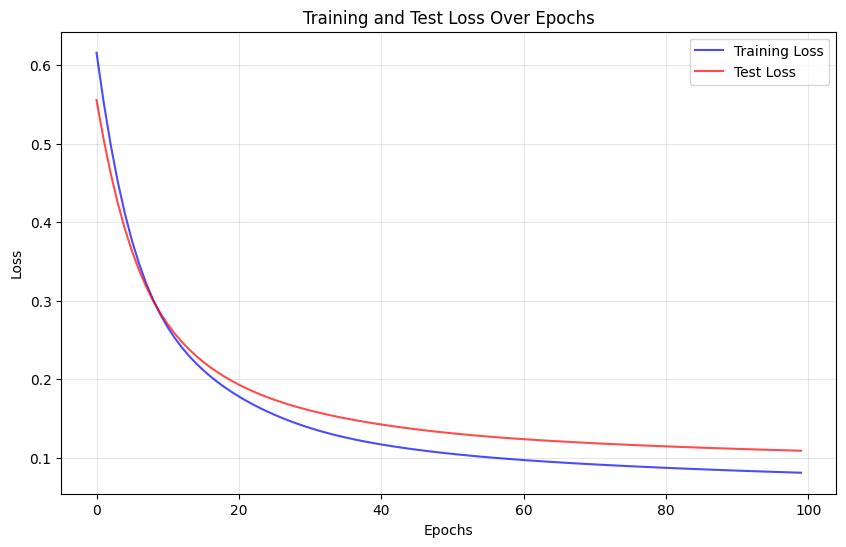

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss', color='blue', alpha=0.7)
plt.plot(test_losses, label='Test Loss', color='red', alpha=0.7)
plt.title('Training and Test Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Model Evaluation


TEST SET RESULTS:
Accuracy:  0.9737
Precision: 0.9726
Recall:    0.9861
F1-Score:  0.9793


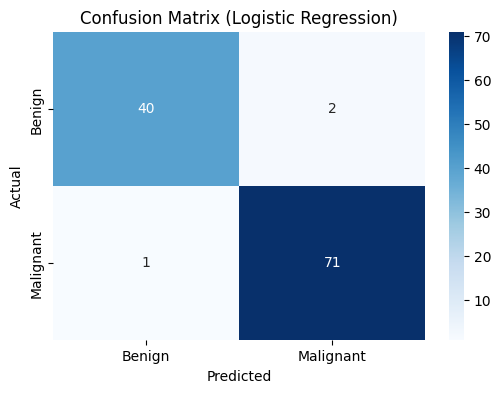

In [11]:
model.eval()
with torch.no_grad():
    # Get predictions (probabilities)
    test_pred_proba = model(X_test_tensor).numpy()
    
    test_pred_binary = (test_pred_proba > 0.5).astype(int).flatten()
    
    y_test_np = y_test_tensor.numpy().flatten()
    
    test_accuracy = accuracy_score(y_test_np, test_pred_binary)
    
    test_precision = precision_score(y_test_np, test_pred_binary)
    
    test_recall = recall_score(y_test_np, test_pred_binary)
    
    test_f1 = f1_score(y_test_np, test_pred_binary)
    
    test_cm = confusion_matrix(y_test_np, test_pred_binary)

print(f"\nTEST SET RESULTS:")
print(f"Accuracy:  {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall:    {test_recall:.4f}")
print(f"F1-Score:  {test_f1:.4f}")

plt.figure(figsize=(6, 4))
sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Logistic Regression)')
plt.show()

# Bonus

In [12]:
class ShallowNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim1=32, hidden_dim2=16):
        super(ShallowNN, self).__init__()
        self.network = torch.nn.Sequential(
            torch.nn.Linear(input_dim, hidden_dim1),
            torch.nn.ReLU(),              # Non-linear activation
            torch.nn.Linear(hidden_dim1, hidden_dim2),
            torch.nn.Tanh(),              # Another non-linearity
            torch.nn.Linear(hidden_dim2, 1),
            torch.nn.Sigmoid()            # Output layer for binary classification
        )

    def forward(self, x):
        return self.network(x)

Epoch [100/100] | Train Loss: 0.1082 | Test Loss: 0.1326


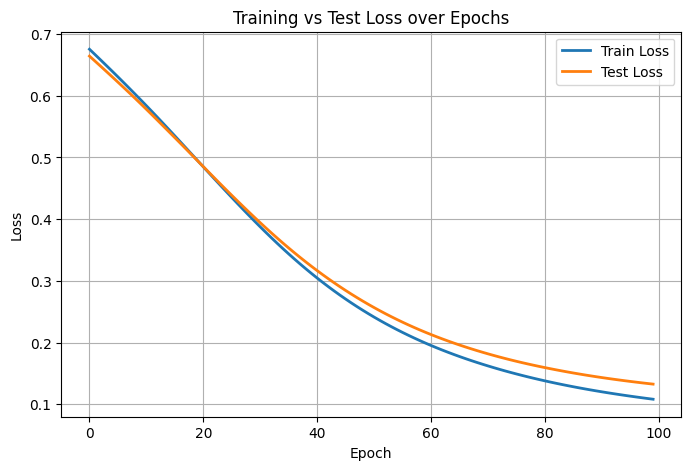

In [13]:
input_dim = X_train.shape[1]
model = ShallowNN(input_dim)

# Define loss and optimizer
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_losses = []
test_losses = []

epochs = 100
for epoch in range(epochs):
    # ---- Training phase ----
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    train_loss = criterion(outputs, y_train_tensor)
    train_loss.backward()
    optimizer.step()

    # ---- Evaluation phase ----
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test_tensor)
        test_loss = criterion(test_outputs, y_test_tensor)

    # Store losses
    train_losses.append(train_loss.item())
    test_losses.append(test_loss.item())

    # Optional logging
    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{epochs}] | Train Loss: {train_loss.item():.4f} | Test Loss: {test_loss.item():.4f}")

# ---- Plot losses ----
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Train Loss', linewidth=2)
plt.plot(test_losses, label='Test Loss', linewidth=2)
plt.title("Training vs Test Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

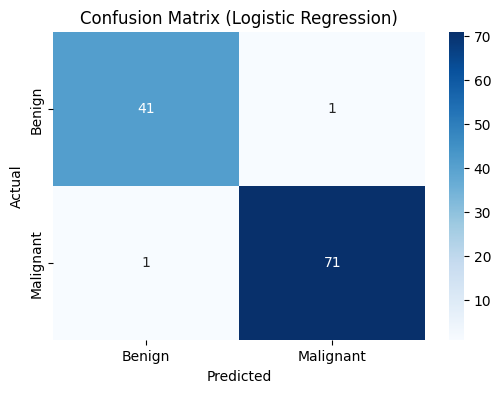

Accuracy: 0.9824561403508771
Precision: 0.9861111111111112


In [14]:
with torch.no_grad():
    y_pred_probs = model(X_test_tensor)
    y_pred = (y_pred_probs > 0.5).float()

cm = confusion_matrix(y_test_tensor, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Logistic Regression)')
plt.show()
print("Accuracy:", accuracy_score(y_test_tensor, y_pred))
print("Precision:", f1_score(y_test_tensor, y_pred))